# Review Text Modeling

### Yelp Review Project

*Group members: Gregg Maloy, Jacob Silver, Justin Williams*

For this part of the project, we wanted to leverage the wealth of rich text data found in each review. Reviews theoretically lend themselves very well to text modeling, because each comes with a set of text that can be treated as set of independent features (*X*) and a semi-quantitative rating from 1-5 that can be treated as a dependent target variable (*y*). Our goal is to build a text model to predict star rating based on the text of a review; if successful, such a model would allow us to identify some components of what makes a high review, and be able to predict a score based on a verbal description of someone's experience. Let's start with our imports:

In [478]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import wordcloud

Now, we'll read in our Yelp review data, which is stored in a 'pickle' file.

In [418]:
#the API sometimes pulled duplicates, so dropping any just in case
df = pd.read_pickle("./data/reviews_df_nyc_no_filter.pkl").drop_duplicates(subset = 'url').reset_index(drop = True)

In [377]:
df.head()

,business_id,id,url,text,rating,time_created,user
0,xnw88LhmiI7_ktRTVYbESw,Rmc4KnJp9ugO86OdeXCipA,https://www.yelp.com/biz/zurilee-restaurant-br...,Great tvs and food at this location. Love th...,5,2023-04-20 12:17:50,"{'id': 'r8CmTE8lT6E2i7_VvV0DIQ', 'profile_url'..."
1,xnw88LhmiI7_ktRTVYbESw,BFYUSkdsvOOZ_WcxtEiQFw,https://www.yelp.com/biz/zurilee-restaurant-br...,I've gone here twice. The pizza selections her...,4,2023-03-16 19:14:15,"{'id': 'WgnSaNq5WXT7iKvbUMQKOw', 'profile_url'..."
2,xnw88LhmiI7_ktRTVYbESw,I_lxGdfYHYtRJbohZpdlYw,https://www.yelp.com/biz/zurilee-restaurant-br...,"When I first came for brunch back in 2018, I t...",4,2021-12-24 09:42:44,"{'id': '4zu7xA2uDDVnnjeZSOQblw', 'profile_url'..."
3,fi8ATHFkHnZgFGJWZUl_BA,sQ1YFJGLBVdzDiprMBRBoQ,https://www.yelp.com/biz/aunts-et-uncles-brook...,The food is delicious (for vegetarians and non...,5,2023-06-24 07:20:29,"{'id': 'PnKiZnF90zJuZ3FKdcSw4Q', 'profile_url'..."
4,fi8ATHFkHnZgFGJWZUl_BA,oJoj3yWLKgP3OOsk9NMl9A,https://www.yelp.com/biz/aunts-et-uncles-brook...,"To be completely honest, this place is aesthet...",3,2023-06-18 15:26:01,"{'id': 'zqXx-3avibBnLOK_oJIUOQ', 'profile_url'..."


Examining our data, we see that in addition to some identifiers and user metadata, we have fields for raw text and rating score. For now, those are the only two fields we need.

In [419]:
df = df[['rating', 'text']]

<BarContainer object of 5 artists>

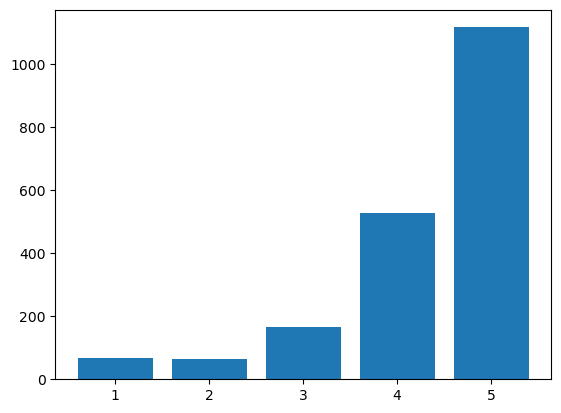

In [431]:
#check counts of each possible rating
plt.bar(data = pd.DataFrame(df['rating'].value_counts()).reset_index().sort_values(by = 'index', ascending = False),
        x = 'index',
        height = 'rating')

As we can see, the data is heavily skewed toward 5-star reviews. While good for those businesses, this imbalance can make modeling challenging, in particular for the review scores with very low volumes like 1- and 2-star reviews.

To account for this, we will categorize reviews into only two categories: 5-star reviews, and *not* 5-star reviews. While this may seem reductive considering the gap between 1 and 4 stars, for our purposes it may actually prove more useful, both in terms of accuracy (which will benefit from the better sampling distribution) and meaning; for any business with at least 4 stars on average, only coveted 5-star reviews raise the average. Linguistically, we also expect that anything less than 5 stars is likely to contain qualifiers (ie. "but the flavor was lacking)--if not, why not rate it a perfect 5 stars?

In [432]:
#5-star reviews will be signified with a *1*
#Everything else will be signified with a  *0*
df['rating'] = df['rating'].map({5:1,
                  4:0,
                  3:0,
                  2:0,
                  1:0})

<BarContainer object of 2 artists>

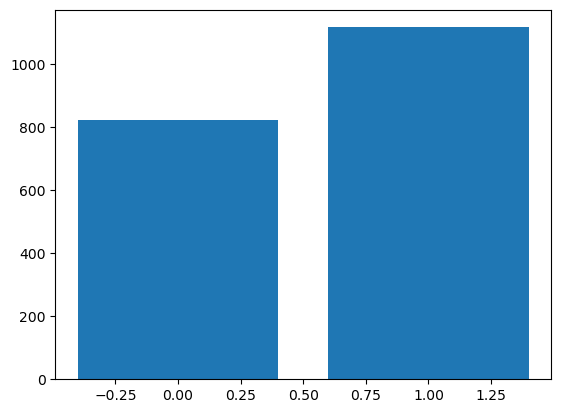

In [433]:
plt.bar(data = pd.DataFrame(df['rating'].value_counts()).reset_index().sort_values(by = 'index', ascending = False),
        x = 'index',
        height = 'rating')

Much better!

In [434]:
#here, we will retain a copy of the original dataframe, for analysis later. In the ensuing steps
#we are manipulating the dataframe in various ways that will make it suitable for modeling, but
#incomprehensible for later reading
df_og = df.copy()

Before we dive any further into the text, we will modify each review so that they are consistently stemmed, meaning each word will be reduced to its "root." This allows words like "amazed" and "amazing" to be treated as the same semantically, helping our feature set not to be diluted by word variations. There are trade-offs associated with this choice, but given our use case and sample, we felt it was the right choice.

In [435]:
#lowercase and tokenize the text
df['text'] = df['text'].apply(str.lower)
df['text'] = df['text'].apply(nltk.word_tokenize)

In [436]:
#initialize the PorterStemmer, a popular tool for the tast
ps = nltk.PorterStemmer()

In [437]:
#stem each token in each review
df['text'] = df['text'].apply(lambda x: [ps.stem(token) for token in x])

In [438]:
#rejoin the text, as it will be re-tokenized when vectorized
df['text'] = df['text'].apply(lambda x: ' '.join(x))

Next, we'll break our data up into training and testing sets using scikit-learn's train_test_split function. Stratification helps even out the sample between target variable categories, and the random_state seed makes the sample consistent across instances of the code.

In [439]:
X_train,X_test,y_train,y_test = train_test_split(df['text'], 
                                                 df['rating'], 
                                                 test_size=0.20,
                                                 stratify = df['rating'],
                                                 random_state = 91)

For vectorization, we'll go with a TF-IDF vectorizer. This means that instead of counting up the occurrence of each word in any given review, it scores that token based on relative frequency. That means that a token will score highly for a review if it is relatively unique to that review, where highly common words (beyond stop words, which are already accounted for in the vectorizer arguments) will be considered less weighty by the model.

In [440]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                      strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                      stop_words = 'english')

In [441]:
#train vectorizer to our text reviews
tfv.fit(X_train)

/Users/jacobsilver/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:541: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                stop_words='english', strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [442]:
#Vectorize our training and test data, then represent each as a 2D matrix
X_train_tfv = tfv.transform(X_train).toarray()
X_test_tfv = tfv.transform(X_test).toarray()

In [443]:
#display feature matrix with names, just for visibility
pd.DataFrame(X_train_tfv, columns = tfv.get_feature_names_out())

,0,1,1 star,10,10 10,10 year,100,11,12,15,...,year food,year old,yelp,yesterday,york,york citi,yum,yummi,zoo,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1546,0.0,0.0,0.0,0.0,0.0,0.0,0.294662,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1547,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1548,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that our data is properly formatted, we can initialize our model. We will use a Multinomial Naive Bayes model, which is popular for text classification because it can work with many features.

In [444]:
#instantiate Multinomial Naive Bayes classifier
tfv_nb = MultinomialNB()
#fit the model to our training data
tfv_nb.fit(X_train_tfv, y_train)

MultinomialNB()

In [445]:
#generate predicted review score (5-star or not 5-star) based on test data
y_pred_tfv = tfv_nb.predict(X_test_tfv)

In [446]:
y_test.value_counts()

1    223
0    165
Name: rating, dtype: int64

In [447]:
#show results
print(classification_report(y_test,y_pred_tfv))

              precision    recall  f1-score   support

           0       0.69      0.37      0.48       165
           1       0.65      0.87      0.75       223

    accuracy                           0.66       388
   macro avg       0.67      0.62      0.61       388
weighted avg       0.67      0.66      0.63       388



While the model performs quite accurately for 5-star reviews (and highly accurately in terms of recall), it has some relative challenges identifying non 5-star reviews, as evidenced by the 0.37 recall on 0-labeled y-values.

Another popular model for this purpose is XGBoost--we can run that model on the same data to see if it performs any better.

In [448]:
#Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                            subsample=0.8, nthread=10, learning_rate=0.1)

In [449]:
#fit XGBoost to training data
xgb_clf.fit(X_train_tfv, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              predictor=None, ...)

In [450]:
#generate predicted review score (5-star or not 5-star) based on test data
y_pred_xgb = xgb_clf.predict(X_test_tfv)

In [451]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.62      0.55      0.58       165
           1       0.69      0.75      0.72       223

    accuracy                           0.66       388
   macro avg       0.66      0.65      0.65       388
weighted avg       0.66      0.66      0.66       388



Nice! While the overall accuracy is the same (66%), it is more evenly distributed among the two score groups.

This is not an especially accurate or powerful model overall--in the future, with a bigger sample of reviews and more comfort with an array of machine learning techniques, we believe we can achieve a more accurate model. Given the use case and stakes, we feel comfortable moving forward with this model for the time being.

**Feature Importance**

Now that we have a model connecting review text to scores, we can work backwards to try to understand which features (in our case, words) the model deemed most important to its determination. By examining those, we may be able to generate learnings for how restaurant owners might be more likely to earn 5-star reviews.

In [457]:
#build dataframe of feature importances
df_feature_importance = pd.DataFrame([dict(zip(tfv.get_feature_names_out(), 
                                               xgb_clf.feature_importances_))]) \
    .transpose() \
    .rename(columns = {0: 'feature_importance'})

In [459]:
df_feature_importance.sort_values(by = 'feature_importance', ascending = False)

,feature_importance
cozi,0.008211
amaz,0.006902
best,0.006863
celebr,0.006209
ca n,0.006179
...,...
got right,0.000000
googl,0.000000
good wa,0.000000
good vibe,0.000000


Let's look at the top most important features and see if we can glean any insights.

In [461]:
list(df_feature_importance.sort_values(by = 'feature_importance', ascending = False).index[:200])

['cozi',
 'amaz',
 'best',
 'celebr',
 'ca n',
 'wa n t',
 'cours',
 'favorit',
 'definit',
 'food servic',
 'write',
 'solid',
 'littl',
 'parti',
 'recommend',
 'onc',
 'way',
 'know',
 'took',
 'decent',
 'absolut',
 'wonder',
 'italian',
 'wa good',
 'gem',
 'space',
 'great',
 'saturday',
 'wa veri',
 'wa delici',
 'everyth',
 't',
 'bar',
 'fantast',
 '3',
 'highli recommend',
 'ok',
 'excit',
 'becaus',
 'wow',
 'home',
 'wa nice',
 'ca n t',
 '8',
 'actual',
 'expect',
 'chef',
 'delici',
 'realli good',
 'wa n',
 'perfect',
 'lot',
 'portion',
 'whi',
 'past',
 'list',
 'high',
 'welcom',
 'love',
 'dinner',
 'earli',
 'thi wa',
 'feel',
 'super',
 'dine',
 'want',
 'pack',
 'complet',
 'neighborhood',
 'd',
 'final',
 'got',
 'ny',
 'birthday',
 'park',
 'alway',
 'season',
 've',
 'cuisin',
 'highli',
 'review',
 'chees',
 'fine',
 'hit',
 'ask',
 'great experi',
 'date',
 'taco',
 'indoor',
 'walk',
 'did',
 'experi',
 'cute',
 'expens',
 'nice',
 'peopl',
 'choic',
 'run',

To view these more easily, we can create a wordcloud, and size each word based on its feature importance.

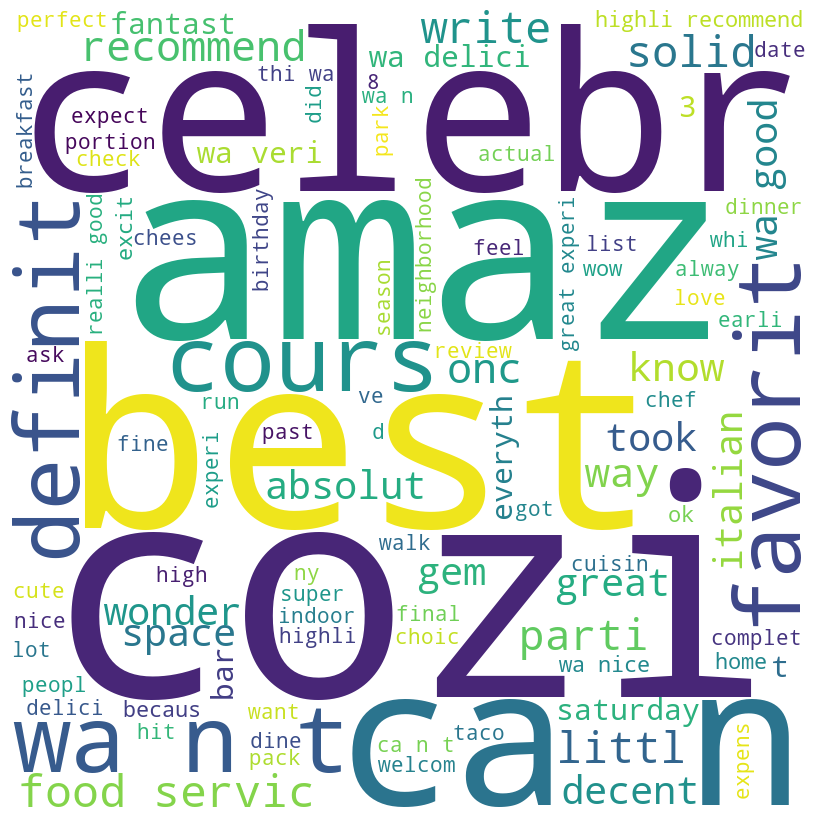

In [477]:
# Convert DataFrame to dictionary
data_dict = df_feature_importance.sort_values(by = 'feature_importance', ascending = False)['feature_importance'].to_dict()

# Generate word cloud
wordcloud = wordcloud.WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=100, 
                relative_scaling=1.0).generate_from_frequencies(data_dict)

# Plot word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

Admittedly, some of these stemmed tokens may not prove valuable to aspiring restaurateurs; for example, it is not surprising that "amazing" ranks highly in terms of importance, and business owners know to strive for that kind of response.

But some important features are much more pointed than that, and may actually say something about the audiences in these particular zip codes. We can learn more about these features one by one using some data reorganization and functions.

In [462]:
#create dataframe for deriving indexes where a particular feature occurs
df_full = pd.DataFrame(data = tfv.transform(df['text']).toarray(),
                       columns = tfv.get_feature_names_out())

In [463]:
#make rating and text column names capital and add to df_full
#(capital letters ensure differentiation with features, which are all lowercase)
df_full = pd.concat([df.rename(columns = {'rating':'RATING',
                                         'text':'TEXT'}),
                     df_full],
                    axis = 1)

In [409]:
def see_reviews_by_feature(feature, df_full, df_og):
    '''Given a particular feature, return a human-readable DataFrame of all reviews
    including that feature/token. Also shows breakdown of 5-star vs. non 5-star reviews
    for that feature.'''
    print(df_og[df_full[feature] != 0]['rating'].value_counts())
    return df_og[df_full[feature] != 0]

Let's examine some exemplar features.

In [468]:
see_reviews_by_feature('cozi', df_full, df_og)

1    19
0     9
Name: rating, dtype: int64


,rating,text
15,1,This place has everything I love about my Broo...
66,1,I looooove this place! Amazing piles of injera...
234,1,This was a girls night out meal and the perfec...
252,1,Cozy establishment. The food was amazing and s...
258,1,Excellent service with warm cozy atmosphere! W...
260,0,Manchego was recommended by a local as a nice ...
364,1,A small friendly cozy restaurant with deliciou...
617,0,It's a very cozy place . The staff is very att...
832,1,I recently visited El Gauchito and had an arna...
884,0,So the ambiance in the restaurant was very cut...


In [469]:
see_reviews_by_feature('welcom', df_full, df_og)

1    24
0     7
Name: rating, dtype: int64


,rating,text
99,1,Very pleased that I finally tried this place. ...
130,1,I've been riding past this place for fever and...
154,1,The food was very good. The portions are giant...
161,1,Very comfortable and welcoming atmosphere - se...
165,1,Get to the Chase:\n\nPros:\n1) Very family fri...
228,1,Came here with my coworkers to have a Iftar. T...
313,0,I want to start by saying that the service her...
345,1,Welcoming cafe and restaurant. We were seated ...
415,1,Noeh went above and beyond. She was so welcomi...
607,1,Best tacos and drinks in Forest hills!! Jocely...


In [467]:
see_reviews_by_feature('celebr', df_full, df_og)

1    27
0     7
Name: rating, dtype: int64


,rating,text
30,1,I celebrated my partner's birthday here and it...
51,0,My Family & I went to Zanmi to celebrate a spe...
60,1,I celebrated my 65th birthday at Black Nile. ...
61,1,I first happened upon this business at their o...
87,1,Had a great dinner here as a late celebration ...
88,0,I came to Faun for a late birthday celebration...
276,1,I celebrated my birthday at the Osteria Brookl...
285,1,"Wonderful spot, took my aunts and uncles here ..."
314,0,I came here to celebrate a work achievement an...
330,1,Came here to celebrate my daughters birthday a...


In [471]:
see_reviews_by_feature('chef', df_full, df_og)

1    21
0     7
Name: rating, dtype: int64


,rating,text
11,0,"Ok, but not going back. \n\nWent here a few ti..."
16,0,We got the vinegar hill pizza with bacon added...
27,1,The food hands down was amazing. I literally w...
84,1,Our favorite spot for amazing seafood and deli...
128,0,Yumz! Everything I had was super fresh. Tried ...
322,0,I was really excited to try this place. I've b...
323,0,Food: The food here was overall delicious. Our...
438,1,The dinning experience with Junsik was extraor...
550,0,"First - and most importantly: ""the Food was de..."
625,1,Food is amazing! The meats there is *chefs kis...


Right off the bat, a couple insights stand out:

- "cozi" and "welcome": Reviewers in these zip codes tend to emphasize cozy, welcoming atmospheres in 5-star reviews. Perhaps people in these neighborhoods prioritize a "homey" vibe as opposed to something more flashy or opulent, something restaurant owners can work to cultivate with decorations, lighting, and staff training.
- "celebr" and "parti": References to celebrations, parties and birthdays were highly predictive of 5-star reviews. This may be both a function of a restaurant being well-suited to host such events, and people being likely to review their experience for a special occasion. Regardless, business owners looking for 5-star reviews would do well to make their venues welcoming for parties and advertise them as such. Delighting those patrons could result in a burst of highly positive ratings.